# Seasonal Forecasts (per year)

## Importing

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
from tqdm import tqdm


## File Creation

In [8]:
def file_creation(variable, name, year):

    temp = variable.to_dataset(name=name)
    temp.to_netcdf(path='/data/ibougoudis/MOAD/files/' + year + '.nc', mode='a', encoding={name:{"zlib": True, "complevel": 9}})
    temp.close()


## Files Loading

In [9]:
bathy = xr.open_dataset('/home/sallen/MEOPAR/grid/bathymetry_202108.nc')
lat = bathy.nav_lat
lon = bathy.nav_lon

path = '/data/ibougoudis/MOAD/files/forecasts/'
months = sorted(os.listdir(path))
year = months[0][0:4]

# Coordinates
daily_dates = pd.date_range(start= months[0]+'01', end=months[1]+'28', freq='D')
coords = dict(time_counter=daily_dates, y=bathy.y, x=bathy.x, member=np.arange(0,20)) 

# Obtaining the names
names = []
for i in sorted(os.listdir(path+months[0]))[::2]:
    names.append(i[i.index('e_')+2:i.index('_n')])


## Calculations (all but wind speed)

In [10]:
for name in tqdm(names):
    if name != 'uas' and name != 'vas':
        
        dataset_all = []
        for month in months:
            folders = sorted(os.listdir(path+month))
            m = int(month[-1]) # The current month

            for folder in folders:
                if name in folder:
                    files = sorted(os.listdir(path+month+'/'+folder))
                    if 'n1-' in folder: # first 10 members
                        i = 0

                    for file in files:
                        ds = xr.open_dataset(path+month+'/'+folder+'/'+file, decode_timedelta=True)

                        ds.coords['lon'] = (ds.coords['lon'] + 180) % 360 - 180
                        ds = ds.sortby(ds.lon)

                        dataset = ds.sel(leadtime=ds.time.dt.month.isin([m]))
                        dataset = dataset.interp(lon=lon,lat=lat, method='nearest')
                        dataset = dataset[name].groupby(dataset.time.dt.day).mean()

                        if i == 0: # first member
                            dataset_member = dataset
                            units = dataset.attrs['units']
                            long_name = dataset.attrs['long_name']
                        else:
                            dataset_member = xr.concat([dataset_member,dataset], dim='member') # every member
                            
                        i = i + 1
    
            dataset_all.append(dataset_member) # every month

        temp = np.concatenate(dataset_all[:], axis=1)
        temp = np.transpose(temp,(1,2,3,0))
        temp = xr.DataArray(temp,coords,dims=('time_counter','y','x','member'), name=long_name, attrs = dict(long_name=long_name, units=units))
        file_creation(temp,long_name,year)


100%|██████████| 3/3 [01:41<00:00, 33.89s/it]


## Calculations (Wind Speed)

In [11]:
dataset_all = []

for month in months:  
    folders = sorted(os.listdir(path+month))
    m = int(month[-1]) # The current month

    folders_uas = []
    folders_vas = []

    for folder in folders:

        if 'uas' in folder:
            folders_uas.append(folder)

        elif 'vas' in folder:
            folders_vas.append(folder)

    for i in range(0, len(folders_uas)):
        files_uas = sorted(os.listdir(path+month+'/'+folders_uas[i]))
        files_vas = sorted(os.listdir(path+month+'/'+folders_vas[i]))

        for j in range(0, len(files_uas)):
    
            ds = xr.open_dataset(path+month+'/'+folders_uas[i]+'/'+files_uas[j], decode_timedelta=True)
            ds2 = xr.open_dataset(path+month+'/'+folders_vas[i]+'/'+files_vas[j], decode_timedelta=True)

            ds.coords['lon'] = (ds.coords['lon'] + 180) % 360 - 180
            ds = ds.sortby(ds.lon)
            ds2.coords['lon'] = (ds2.coords['lon'] + 180) % 360 - 180
            ds2 = ds2.sortby(ds2.lon)
                
            dataset = ds.sel(leadtime=ds.time.dt.month.isin([m]))
            dataset2 = ds2.sel(leadtime=ds2.time.dt.month.isin([m]))

            ws = np.sqrt(dataset['uas']**2 + dataset2['vas']**2)
            ws = ws.interp(lon=lon,lat=lat, method='nearest')
            ws = ws.groupby(ws.time.dt.day).mean()

            if (i == 0) and (j ==0): # first member
                dataset_member = ws
                units = 'm/s'
                long_name = 'Mean_wind_speed'
            else:
                dataset_member = xr.concat([dataset_member,ws], dim='member') # every member

    dataset_all.append(dataset_member) # every month

temp = np.concatenate(dataset_all[:], axis=1)
temp = np.transpose(temp,(1,2,3,0))
temp = xr.DataArray(temp,coords,dims=('time_counter','y','x','member'), name=long_name, attrs = dict(long_name=long_name, units=units))
file_creation(temp,long_name,year)
       

In [3]:
test = xr.open_dataset('/data/ibougoudis/MOAD/files/forecasts/2007.nc')
test

<xarray.Dataset> Size: 62GB
Dimensions:                                                          (
                                                                      time_counter: 181,
                                                                      y: 898,
                                                                      x: 398,
                                                                      member: 20)
Coordinates:
  * time_counter                                                     (time_counter) datetime64[ns] 1kB ...
  * y                                                                (y) int64 7kB ...
  * x                                                                (x) int64 3kB ...
  * member                                                           (member) int32 80B ...
Data variables:
    Sea Level Pressure                                               (time_counter, y, x, member) float64 10GB ...
    Near-Surface Air Temperature                                     (time_counter, y, x, member) float64 10GB ...
    Liquid Water Equivalent Thickness of Total Precipitation Amount  (time_counter, y, x, member) float64 10GB ...
    Net Longwave Surface Radiation                                   (time_counter, y, x, member) float64 10GB ...
    Net Shortwave Surface Radiation                                  (time_counter, y, x, member) float64 10GB ...
    Mean_wind_speed                                                  (time_counter, y, x, member) float64 10GB ...

In [6]:
ds0 = xr.open_dataset('/data/ibougoudis/MOAD/files/inputs/jan_apr.nc')
mask = ds0['Diatom'][0]

In [7]:
test2 = test.where(mask>0)

In [13]:
test = xr.open_dataset('/data/ibougoudis/MOAD/files/2007.nc')
test2 = xr.open_dataset('/data/ibougoudis/MOAD/files/2008.nc')

test3 = xr.concat((test,test2), dim='time_counter')


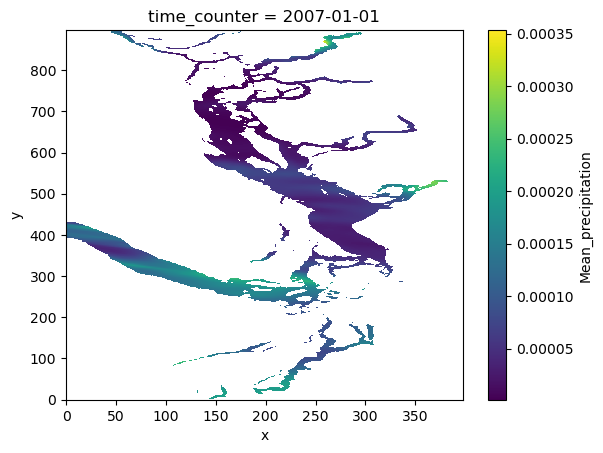

In [17]:
ds0['Mean_precipitation'][0].plot()

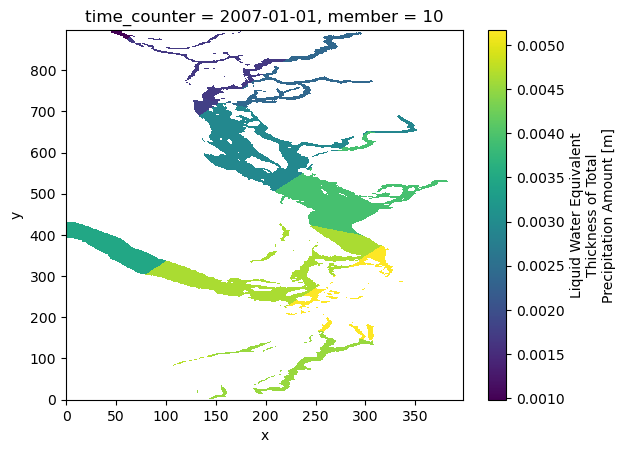

In [16]:
test2['Liquid Water Equivalent Thickness of Total Precipitation Amount'][0,:,:,10].plot()

In [25]:
test2['Liquid Water Equivalent Thickness of Total Precipitation Amount'].encoding

{}

{'dtype': dtype('float64'),
 'zlib': True,
 'szip': False,
 'zstd': False,
 'bzip2': False,
 'blosc': False,
 'shuffle': True,
 'complevel': 9,
 'fletcher32': False,
 'contiguous': False,
 'chunksizes': (285, 113, 50),
 'preferred_chunks': {'time_counter': 285, 'y': 113, 'x': 50},
 'source': '/data/ibougoudis/MOAD/files/inputs/jan_apr.nc',
 'original_shape': (2280, 898, 398),
 '_FillValue': np.float64(nan)}